<a href="https://colab.research.google.com/github/evmpython/projeto_chuva_vale/blob/main/01_regiao_SPLMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1° Passo:** Instalando as bibliotecas

In [1]:
# Instalando proplot
!pip install -q proplot

# Instalando o cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

Found existing installation: shapely 2.0.6
Uninstalling shapely-2.0.6:
  Successfully uninstalled shapely-2.0.6


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

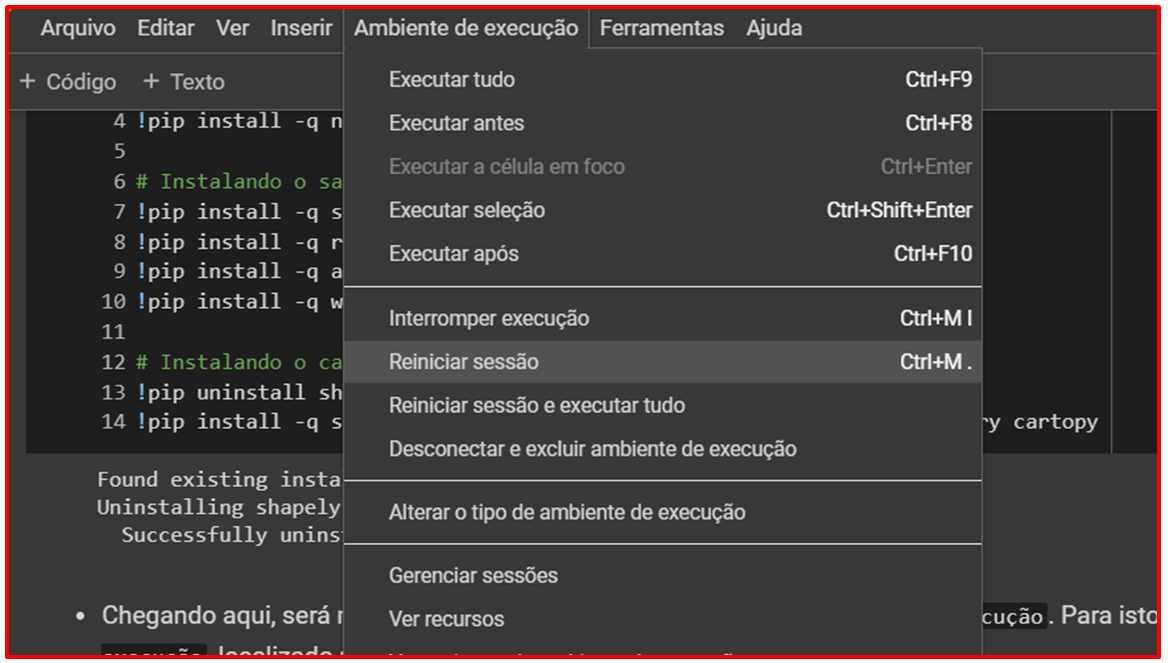

In [2]:
# Instalando rasterio
!pip install -q rasterio pyproj rioxarray geopandas salem descartes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00


# **2° Passo:** Monta Drive

In [36]:
# montra drive
from google.colab import drive
drive.mount('/content/drive')

# caminho da pasta do código
dir = '/content/drive/MyDrive/2-PESQUISA/artigo_primeiro_mestrado_raquel/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **3° Passo:** Download de informações auxiliares

In [23]:
!wget -c https://raw.githubusercontent.com/evmpython/projeto_chuva_vale/refs/heads/main/utils/latlon_sensores_brasildat.txt

!wget -c https://raw.githubusercontent.com/evmpython/projeto_chuva_vale/refs/heads/main/utils/latlon_sensores_splma.txt

!wget -c https://github.com/evmpython/artigo_primeiro_mestrado_Raquel/raw/refs/heads/main/elevacao_brasil.nc

!wget -c https://github.com/evmpython/relevo/raw/refs/heads/main/input/gebco_2021_n-15.0_s-30.0_w-55.0_e-40.0.tif

--2024-11-21 21:09:56--  https://raw.githubusercontent.com/evmpython/projeto_chuva_vale/refs/heads/main/utils/latlon_sensores_brasildat.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2024-11-21 21:09:56--  https://raw.githubusercontent.com/evmpython/projeto_chuva_vale/refs/heads/main/utils/latlon_sensores_splma.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2024-11-21 21:09:56--  h

# **4° Passo:** Importando as bibliotecas

In [4]:
import numpy as np                          # Biblioteca para trabalhar com matrizes
import proplot as pplt                      # Biblioteca para gerar figuras
import os                                   # Biblioteca para acessar o sistema operacional
import cartopy.crs as ccrs                  # Biblioteca para trabalhar com projeções de mapas
import cartopy.io.shapereader as shpreader  # Biblioteca para ler arquivos shapefiles
import xarray as xr
import rasterio as rio                      # Biblioteca para trabalhar com arquivos raster
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray
import time
import salem

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


# **5° Passo:** Declarando funções

In [26]:
#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                aneis (lista): tamanho do raio do círculo em km
                lon_r (float): valor da longitude do centro do círculo em graus
                lat_r (float): valor da latitude do centro do círculo em graus
                color (str): cor do raio do círculo
                label (str): legenda

    Parâmetros de saída:
                latitude e longitude que delimita círculos de distância centrado no radar e plota os círculos
    """

    import geopy
    from geopy import distance

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label, linestyle='-')

#**PARTE 1:** Lendo arquivo da localização dos sensores da Brasildat e SPLMA

In [28]:
# Brasildat
df_br = pd.read_csv('/content/latlon_sensores_brasildat.txt')
df_br

,sigla,lat,lon
0,BRS34,-23.481848,-46.500522
1,BRS35,-23.513762,-46.155665
2,BRS36,-23.331707,-46.655373
3,BRS37,-23.702194,-46.825176
4,BRS38,-23.559321,-46.733542
5,BRS39,-23.707770,-46.410072
6,BRS40,-23.601951,-47.094267


In [29]:
# SPLMA
df_splma = pd.read_csv('/content/latlon_sensores_splma.txt', sep=';')
df_splma

,id,name,lat,lon,alt(m),delay(ns),board_rev,rec_ch
0,A,MKZ,-23.487797,-46.831648,808.80,833,3,8
1,B,UAB,-23.702219,-46.825139,783.80,743,3,8
2,C,PCT,-23.650711,-46.621882,825.30,711,3,8
3,D,FEI,-23.725709,-46.579560,828.30,725,3,8
4,E,IFP,-23.561596,-46.735082,805.60,726,3,10
5,F,CSP,-23.524174,-46.621844,750.30,722,3,8
6,G,RBP,-23.707824,-46.410026,823.40,744,3,8
7,H,PQC,-23.576659,-46.459295,842.24,867,3,8
8,J,ULE,-23.481884,-46.500595,760.90,731,3,8
9,K,MGC,-23.513758,-46.155668,765.42,737,3,8


In [30]:
# verificando o tipo das colunas da tabela
df_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sigla   7 non-null      object 
 1   lat     7 non-null      float64
 2   lon     7 non-null      float64
dtypes: float64(2), object(1)
memory usage: 296.0+ bytes


#**PARTE 2:** Plota figura de relevo: usando geotif

- **DADOS UTILIZADOS:** São utilizados dados de relevo do GEBCO_2021 Grid:
    1. Acessar o [site](https://download.gebco.net/) do dado de relevo
    2. Selecionar a região de interesse
    3. Escolher o formato **GeoTIFF** - Opção **Grid**
    4. Clicar em **Add to basket**, seguido por **View basket** e em **Download your data**
    4. Baixar a figura e inserir no drive, no mesmo local do código

##**Lendo o arquivo**

In [84]:
# define os limites da imagem
latmin, latmax, lonmin, lonmax = -24.48, -22.61, -47.65, -45.63

# leitura do arquivo
filename = 'gebco_2021_n-15.0_s-30.0_w-55.0_e-40.0.tif'
data = rioxarray.open_rasterio(f'/content/{filename}')

# recorta o dado
data = data.sel(x=slice(lonmin, lonmax), y=slice(latmax, latmin))

# exibe os dados
data

<xarray.DataArray 'elevation' (band: 1, y: 449, x: 485)> Size: 436kB
[217765 values with dtype=int16]
Coordinates:
  * band     (band) int64 8B 1
  * x        (x) float64 4kB -47.65 -47.64 -47.64 ... -45.64 -45.64 -45.63
  * y        (y) float64 4kB -22.61 -22.61 -22.62 ... -24.47 -24.47 -24.48
    crs      int64 8B 0
Attributes: (12/63)
    lat#axis:                        Y
    lat#long_name:                   latitude
    lat#sdn_parameter_name:          Latitude north
    lat#sdn_parameter_urn:           SDN:P01::ALATZZ01
    lat#sdn_uom_name:                Degrees north
    lat#sdn_uom_urn:                 SDN:P06::DEGN
    ...                              ...
    sdn_uom_urn:                     SDN:P06::ULAA
    standard_name:                   height_above_mean_sea_level
    units:                           m
    _FillValue:                      -32767
    scale_factor:                    1.0
    add_offset:                      0.0

## **Plota figura de relevo**

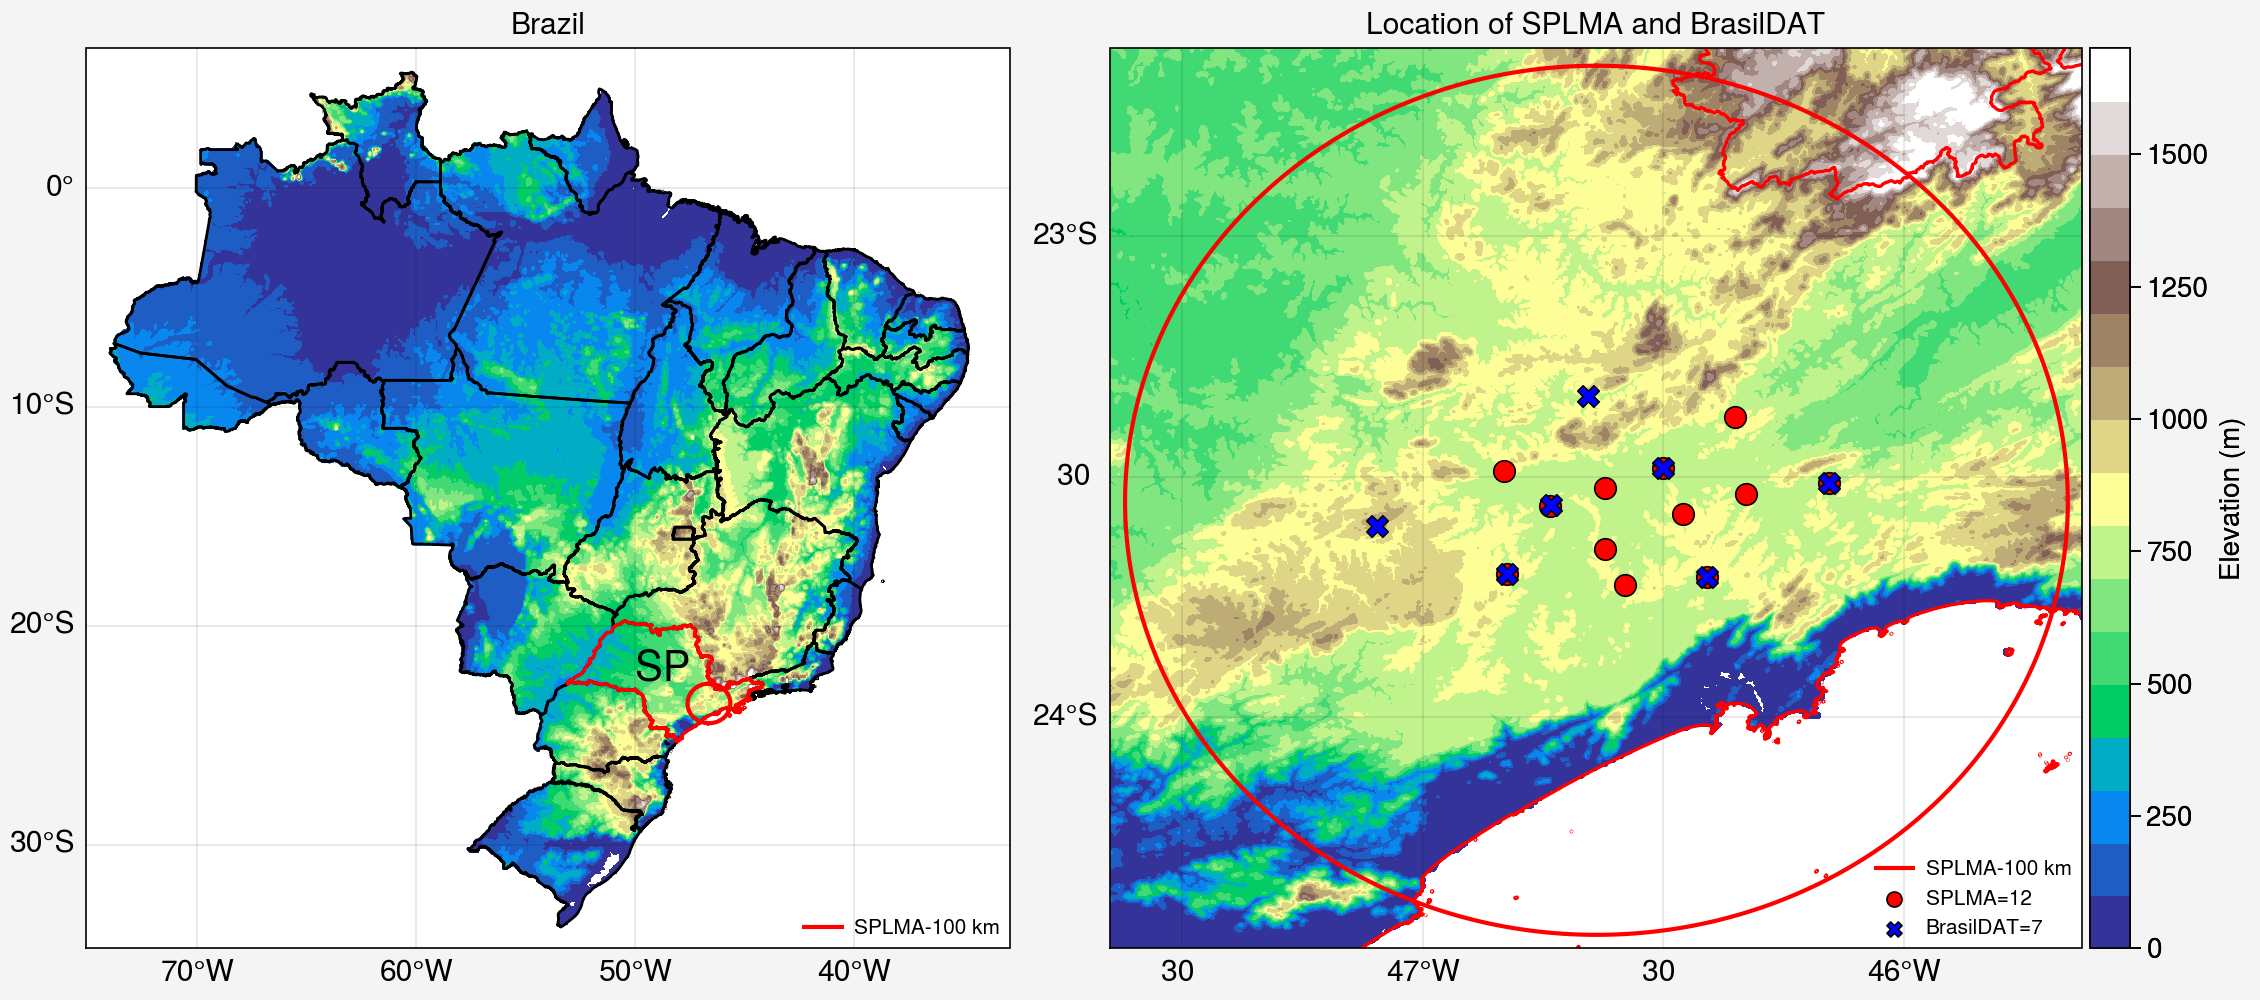

CPU times: user 13.5 s, sys: 1.06 s, total: 14.6 s
Wall time: 15.9 s


In [91]:
%%time
# moldura da figura
fig, ax = pplt.subplots(figsize=(11.3, 5), nrows=1, ncols=2, tight=True, proj='pcarree')

#========================================================================================================================#
#                                                   FIG-1
#========================================================================================================================#
# leitura do arquivo
dset_brasil = xr.open_dataset('/content/elevacao_brasil.nc')

# mapa de contornos preenchidos
map1 = ax[0].contourf(dset_brasil['x'],
                      dset_brasil['y'],
                      dset_brasil['elevation'].squeeze(),
                      cmap='terrain',
                      levels=pplt.arange(0, 1700, 100))

# shapefile dos Estados
shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/refs/heads/main/estados_do_brasil/BR_UF_2019.shp').geometries())
ax[0].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor= 'black', facecolor='none', linewidth=1.)

# shapefile de SP
shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp').geometries())
ax[0].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor= 'red', facecolor='none', linewidth=1.2)

# plota sigla do Estado de SP
ax[0].annotate('SP', xy=(-50., -22.5), fontsize=15, color='black')

# formatação dos eixos
ax[0].format(coast=False, borders=False, innerborders=False,
             labels=True,
             latlines=10, lonlines=10,
             latlim=(float(dset_brasil['y'][0])+1.1, float(dset_brasil['y'][-1])-1.0),
             lonlim=(float(dset_brasil['x'][0])-1.1, float(dset_brasil['x'][-1])-4.0),
             title='Brazil',
             small='15px', large='15px')

#========================================================================================================================#
#                                                   FIG-2
#========================================================================================================================#
# formatação dos eixos
ax[1].format(coast=False, borders=False, innerborders=False,
             labels=True,
             latlines=0.5,
             lonlines=0.5,
             latlim=(latmin, latmax),
             lonlim=(lonmin, lonmax),
             title=f'Location of SPLMA and BrasilDAT',
             small='15px',
             large='15px')

# plota figura
map1 = ax[1].contourf(data['x'],
                      data['y'],
                      data[0,:,:],
                      cmap='terrain',
                      levels=pplt.arange(0, 1700, 100))

# shapefile de SP
shapefile = list(shpreader.Reader('https://github.com/evmpython/shapefile/raw/main/UFs/SP/SP_UF_2019.shp').geometries())
ax[1].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor= 'red', facecolor='none', linewidth=1.2)

# SPLMA
ax[1].scatter(df_splma['lon'].values,
              df_splma['lat'].values,
              transform=ccrs.PlateCarree(),
              marker='o',
              s=60,
              color='red', edgecolor='black',
              label=f'SPLMA={df_splma.shape[0]}',
              zorder=2)

# BRASILDAT
ax[1].scatter(df_br['lon'].values,
              df_br['lat'].values,
              transform=ccrs.PlateCarree(),
              marker='X',
              s=60,
              color='blue', edgecolor='black',
              label=f'BrasilDAT={df_br.shape[0]}',
              zorder=2)

# anel de 100 km da SPLMA
lon_center_splma_LMA = -46.638810
lat_center_splma_LMA = -23.548974
evm_plota_aneis_em_geral([100], lon_center_splma_LMA, lat_center_splma_LMA, 'red', 'SPLMA-100 km')

# plota barra de cores da figura
fig.colorbar(map1, loc='right', label='Elevation (m)', ticks=250, ticklabelsize=10, labelsize=10, space=-1.2)

# adiciona legenda
ax.legend(loc='lr',
          ncols=1,
          frameon=False,
          prop={'size': 7.5},
          markerscale=0.7)

# salva figura
fig.save(f'{dir}regiao_splma.png',
         bbbox_inches='tight',
         dpi=300,
         edgecolor="white")

# exibe na tela
pplt.show()